In [1]:
import numpy as np
import matplotlib.pylab as plt
import sklearn.metrics as skm
import sys
sys.path.insert(0, '../zdrojaky/logreg')
from logreg import LogReg
np.set_printoptions(suppress=True)

# Logistická regrese

Praktickou ukázkou použití logistické regrese (nebo libovolné jiné vhodné klasifikační metody) je určování, zda daný pixel získaný z fotografie obličeje patří ke kůži (Skin) či nikoliv (NonSkin). Pro testování algorimů se využívá databáze *Skin Segmentation Dataset* (Bhatt & Dhall) získaná náhodným vzorkováním RGB (Red-Green-Blue) hodnot pixelů z obličejů různých věkových skupin (young-middle-old) a rasových skupin (white-black-asian) z databází FERET a PAL. Dataset obsahuje celkem 245 057 řádků s hodnotami B, G, R a příslušností k třídě Skin (1) resp. NonSkin (2). Z toho je 194 198 vzorků NonSkin a 50 859 Skin. V tomto příkladu použijeme 1000 náhodně vybraných vzorků a sekvenčně je zkusíme oklasifikovat logistickou regresí.

Tři náhodně vybrané datové řádky:

    ---
    B, G, R, Class
    242, 169, 161,   2
    218, 211, 202,   2
    110, 150, 209,   1
    ---
    
**Použijeme regresor ve tvaru $x_t = [1, B_t, G_t, R_t]$, normální apriorní distribuci $\mathcal{N}$(**_0_**, 100**_I_**) a mez _m_=0.5.**

Nejprve načteme data. Protože jsou uspořádána, náhodně je promícháme.

In [2]:
np.random.seed(1234)
ndat = 5000

fn = 'Skin_NonSkin.txt'
data = np.loadtxt(fn)
np.random.shuffle(data)
data = data[:ndat]

print("První tři řádky v pořadí [B, G, R, class]:")
print(data[:3])

První tři řádky v pořadí [B, G, R, class]:
[[242. 169. 161.   2.]
 [218. 211. 202.   2.]
 [110. 150. 209.   1.]]


Všimněte si, že třídy jsou oklasifikovány jako 1 a 2 (Skin a NonSkin). 


**Úkol 1: Musíme tedy od posledního sloupce odečíst jedničku.**


**Úkol 2: Rozdělte data na regresory (BGR) - proměnná `X` a třídy - proměnná `y`. Upravte regresor, aby odpovídal požadované podobě (sloupec jedniček).**

In [3]:
data[:,3] -= 1
X = np.hstack((np.ones((data.shape[0],1)), data[:,:3]))
y = data[:,-1]

print("První tři regresory [1, B, G, R]:\n", X[:3])
print("\nPrvní tři měření yt:\n", y[:3])

První tři regresory [1, B, G, R]:
 [[  1. 242. 169. 161.]
 [  1. 218. 211. 202.]
 [  1. 110. 150. 209.]]

První tři měření yt:
 [1. 1. 0.]


Použijeme apriorní distribuci $\mathcal{N}([0, 0, 0, 0], 100I_{4\times 4}).$

In [4]:
#%% Prior
beta_hat = np.zeros(X.shape[-1])
Sigma = np.eye(X.shape[-1]) * 100.
prior = LogReg(mean=beta_hat, Sigma=Sigma)

Pustíme odhad - apriorno updatujeme vždy o jeden regresor a pozorovanou třídu (Skin-NonSkin)

In [5]:
#%% Estimation
for xt, yt in zip(X, y):
    prior.update(yt, xt)
    prior.log()

Podívejme se na vývoj odhadů a jejich neurčitosti. Ta je dána variancemi odhadů - to jsou diagonální prvky v kovariančních maticích (proč?). Podívejme se také, jaké jsou rozměry logů.

In [6]:
beta_log = np.array(prior.mean_log)
beta_vars_log = np.array(prior.Sigma_log)

print(f'Rozměr beta_log: {beta_log.shape}')
print(f'Rozměr beta_vars_log: {beta_vars_log.shape}')

Rozměr beta_log: (5000, 4)
Rozměr beta_vars_log: (5000, 4, 4)


`beta_log` má tolik řádků, kolik bylo dat (odhadů). `beta_vars_log` jsou kovariční matice uspořádané do pole, kde první rozměr je počet dat (odhadů) a další rozměry jsou celé kovarianční matice. Chceme ale jen diagonální prvky - variance jednotlivých prvků vektoru $\hat\beta$.

In [7]:
beta_vars_log = beta_vars_log.diagonal(axis1=1, axis2=2)
print(f'Nový rozměr beta_vars_log: {beta_vars_log.shape}')

Nový rozměr beta_vars_log: (5000, 4)


Vykreslíme si vývoj odhadů. V levém sloupci jsou postupně hodnoty všech složek $\hat\beta$ pro `1`, `R`, `G`, `B`. V pravém je vývoj směrodatné odchylky. Jak je vidět, nejpomaleji konverguje odhad pro offset.

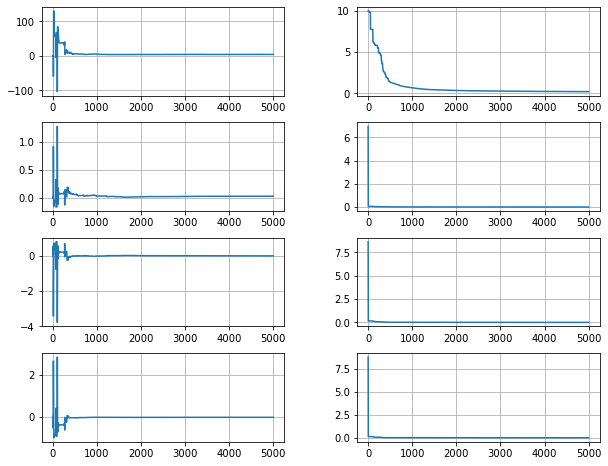

In [8]:
plt.figure(1, figsize=(10,8))
for i in range(beta_hat.size):
    plt.subplot(beta_hat.size, 2, 2*i+1)
    plt.plot(beta_log[:,i])
    plt.subplot(beta_hat.size, 2, 2*i+2)
    plt.plot(np.sqrt(beta_vars_log[:,i]))

Finální odhady $\hat\beta$ jsou:

In [9]:
print(f'odhad beta = {np.array2string(beta_log[-1], precision=4)}')

odhad beta = [ 4.1873  0.0234 -0.0041 -0.0342]


Podívejme se ještě na vývoj Brierova skore. Očekávali bychom, že s přibývajícími daty bude odhad přesnější, tj. skore bude postupně klesat.

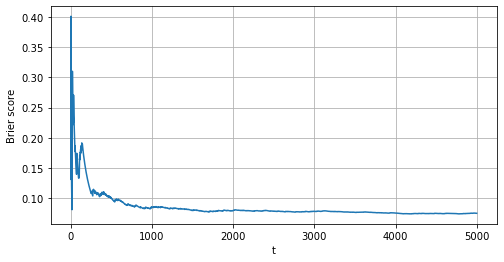

In [10]:
plt.figure(figsize=(8, 4))
plt.plot(prior.brier_score_log)
plt.xlabel('t')
plt.ylabel('Brier score')
plt.show()

Do finále můžeme spočítat nějaké metriky pomocí sklearn.

In [11]:
# Matice záměn
print('Matice záměn:')
cm = skm.confusion_matrix(prior.true_vals, prior.binary_preds)
print(cm)

print('\nClassification report')
report = skm.classification_report(prior.true_vals, prior.binary_preds)
print(report)

Matice záměn:
[[ 870  205]
 [ 237 3688]]

Classification report
              precision    recall  f1-score   support

         0.0       0.79      0.81      0.80      1075
         1.0       0.95      0.94      0.94      3925

    accuracy                           0.91      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.91      0.91      0.91      5000



### Porovnání se statickou logistickou regresí

V `sklearn` je k dispozici modul pro logistickou regresi z hotového balíku dat. Ten využívá numerickou optimalizaci, jež je dražší, než naše laplaceovská. A neumí jet sekvenčně, tj. pro každé nové měření bychom museli kompletně přepočítat na všech datech. Porovnejme aspoň výsledky:

In [12]:
from sklearn.linear_model import LogisticRegression

`sklearn.LogisticRegression` má extra parametr na fitování offsetu, čili matice X nebude obsahovat jedničky:

In [13]:
print(data[:3])
X = data[:,:3]
y = data[:,-1]
X.shape

[[242. 169. 161.   1.]
 [218. 211. 202.   1.]
 [110. 150. 209.   0.]]


(5000, 3)

Pustíme fitování:

In [14]:
clf = LogisticRegression(random_state=0, solver='lbfgs',fit_intercept=True,
                         multi_class='auto').fit(X, y)

Porovnejme nafitované koeficienty $\hat\beta$:

In [15]:
print(f'Staticky: {np.array2string(np.c_[clf.intercept_, clf.coef_], precision=4)}')
print(f'Sekvenčně: {np.array2string(prior.mean, precision=4,)}')

Staticky: [[ 4.2672  0.0251 -0.0056 -0.0348]]
Sekvenčně: [ 4.1873  0.0234 -0.0041 -0.0342]


In [16]:
print('Matice záměn staticky:')
preds = clf.predict(X)
print(skm.confusion_matrix(prior.true_vals, preds))

print('\nReport statického fitování:')
print(skm.classification_report(prior.true_vals, preds))

Matice záměn staticky:
[[ 890  185]
 [ 219 3706]]

Report statického fitování:
              precision    recall  f1-score   support

         0.0       0.80      0.83      0.82      1075
         1.0       0.95      0.94      0.95      3925

    accuracy                           0.92      5000
   macro avg       0.88      0.89      0.88      5000
weighted avg       0.92      0.92      0.92      5000



Nenechme se mýlit pocitem, že statické fitování je (o chlup) lepší! Bayesovské sekvenční fitování totiž ztratilo nějaké body na prvních datech, kde ještě o $\beta$ moc nevědělo, ale už ho odhadovalo. Statický výpočet nejprve spočetl odhady na *všech* datech a následně s těmito odhady predikoval. Pro férové porovnání bychom museli pouštět `sklearn.LogisticRegression` postupně na jednom, dvou,... měřeních. A to by trvalo celou věčnost. V tom je výrazná výhoda sekvenčního modelování.

Dalším velkým rozdílem je, že v dynamickém modelování jsme zvolili jen jeden krok Newtonovy metody. Kdybychom se trochu víc rozmáchli, byl by výsledek také lepší. Oproti tomu statické modelování použilo L-BFGS a mělo k dispozici teoreticky až 100 iterací.